In [2]:
using CSV, DataFrames
using FileIO, Dates
using Plots, StatsPlots
using StatsBase

In [3]:
include("./src/cubes.jl")
include("./src/network.jl")
include("./src/motifs_discovery.jl")
include("./src/motifs_analysis.jl")

volume_tetrahedrons (generic function with 1 method)

### Read data

In [28]:
path = "./data/"
region = "california"
filepath = path * region * ".csv"

"./data/california.csv"

In [29]:
california_full = CSV.read(filepath, DataFrame);

807081×7 DataFrame
    Row │ Datetime                 Latitude  Longitude  Depth    Magnitude  Ev ⋯
        │ DateTime                 Float64   Float64    Float64  Float64    St ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │ 1932-01-02T16:42:53.680    33.903   -117.645      6.0       2.73  eq ⋯
      2 │ 1932-01-03T17:58:50.010    32.0     -116.0        6.0       3.0   eq
      3 │ 1932-01-04T21:30:50.960    33.771   -117.494      6.0       2.0   eq
      4 │ 1932-01-05T02:37:57.960    33.559   -118.442      6.0       1.5   eq
      5 │ 1932-01-06T08:08:58.620    34.143   -117.475      6.0       2.0   eq ⋯
      6 │ 1932-01-07T02:29:52.370    33.992   -118.194      6.0       1.0   eq
      7 │ 1932-01-07T05:39:53.730    34.094   -117.263      6.0       1.0   eq
      8 │ 1932-01-07T14:55:53.920    32.0     -116.0        6.0       3.0   eq
   ⋮    │            ⋮                ⋮          ⋮         ⋮         ⋮         ⋱
 807075 │ 2023-02-05T04:57:53.280    33.226   -116.301     14.5       1.36  eq ⋯
 807076 │ 2023-02-05T05:06:52.870    34.85    -116.995      7.8       1.72  eq
 807077 │ 2023-02-05T05:07:53.810    33.247   -117.085      2.9       0.9   eq
 807078 │ 2023-02-05T05:46:50.450    33.733   -117.96      25.9       1.74  eq
 807079 │ 2023-02-05T06:01:53.970    33.703   -117.628      0.8       1.56  eq ⋯
 807080 │ 2023-02-05T06:15:56.490    34.187   -117.01      11.0       1.09  eq
 807081 │ 2023-02-05T06:59:55.900    32.333   -115.37      12.6       2.02  eq
                                               2 columns and 807066 rows omitted

### DateTime Cleanup

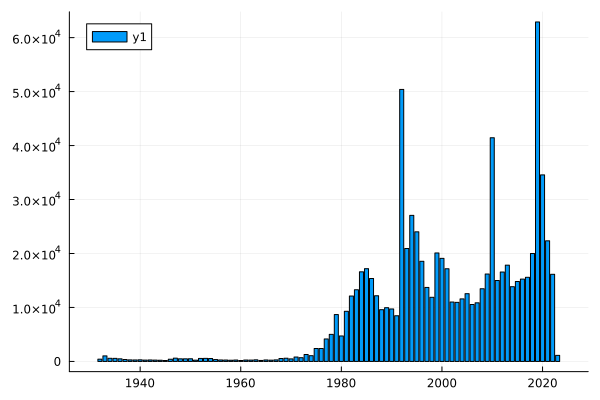

In [39]:
california_full[:, :year] = year.(california_full.Datetime)
quakes_per_year_full = combine(groupby(california_full, [:year]), nrow => :count);
bar(quakes_per_year_full.year, quakes_per_year_full.count)

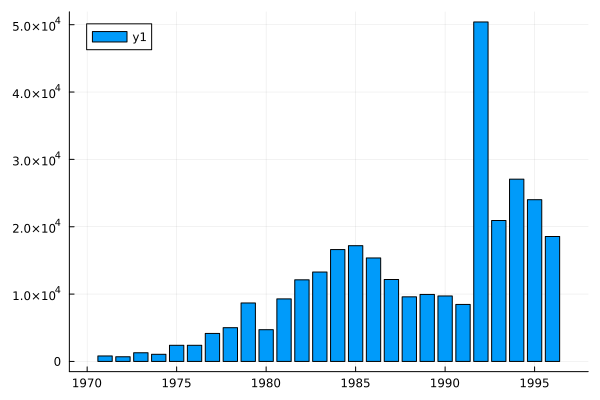

In [52]:
bar(quakes_per_year_full[40:65,:].year, quakes_per_year_full[40:65,:].count)

In [54]:
california = california_full[california_full.Datetime .> DateTime(1978,1,1,0,0,0),:];
california

779591×8 DataFrame
    Row │ Datetime                 Latitude  Longitude  Depth    Magnitude  Ev ⋯
        │ DateTime                 Float64   Float64    Float64  Float64    St ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │ 1978-01-01T01:02:59.740    33.999   -117.109     14.9       1.76  eq ⋯
      2 │ 1978-01-01T01:02:57.230    33.994   -117.106     14.4       1.61  eq
      3 │ 1978-01-01T08:51:59.550    32.809   -115.456     10.0       1.92  eq
      4 │ 1978-01-01T09:49:58.100    35.114   -119.024      0.5       1.71  eq
      5 │ 1978-01-01T10:30:51.490    34.939   -119.079      5.5       1.3   eq ⋯
      6 │ 1978-01-01T11:37:58.850    33.26    -115.983      5.9       1.96  eq
      7 │ 1978-01-01T12:55:52.080    32.693   -115.385      6.8       1.8   eq
      8 │ 1978-01-01T12:55:58.260    32.69    -115.377     10.0       2.22  eq
   ⋮    │            ⋮                ⋮          ⋮         ⋮         ⋮         ⋱
 779585 │ 2023-02-05T04:57:53.280    33.226   -116.301     14.5       1.36  eq ⋯
 779586 │ 2023-02-05T05:06:52.870    34.85    -116.995      7.8       1.72  eq
 779587 │ 2023-02-05T05:07:53.810    33.247   -117.085      2.9       0.9   eq
 779588 │ 2023-02-05T05:46:50.450    33.733   -117.96      25.9       1.74  eq
 779589 │ 2023-02-05T06:01:53.970    33.703   -117.628      0.8       1.56  eq ⋯
 779590 │ 2023-02-05T06:15:56.490    34.187   -117.01      11.0       1.09  eq
 779591 │ 2023-02-05T06:59:55.900    32.333   -115.37      12.6       2.02  eq
                                               3 columns and 779576 rows omitted

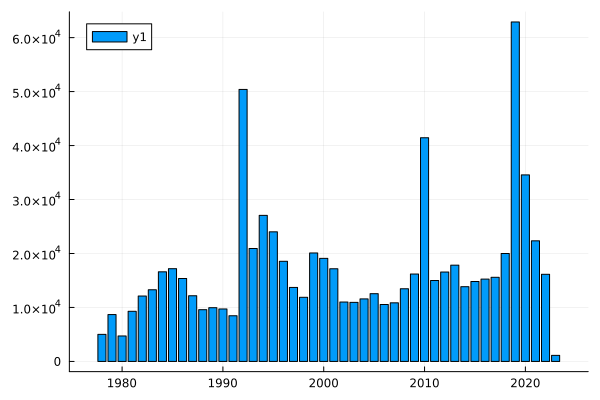

In [55]:
california[:, :year] = year.(california.Datetime)
quakes_per_year = combine(groupby(california, [:year]), nrow => :count);
bar(quakes_per_year.year, quakes_per_year.count)

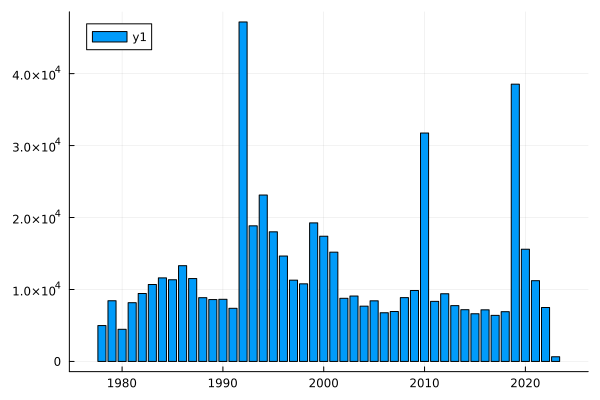

In [60]:
# Filter some magnitudes to see if outliers persist

california_full_mag1 = california[(california.Magnitude .>= 1.0),:];
quakes_per_year_mag1 = combine(groupby(california_full_mag1, [:year]), nrow => :count);

california_full_mag2 = california[(california.Magnitude .>= 2.0) ,:];
quakes_per_year_mag2 = combine(groupby(california_full_mag2, [:year]), nrow => :count);

california_full_mag3 = california[(california.Magnitude .>= 3.0) ,:];
quakes_per_year_mag3 = combine(groupby(california_full_mag3, [:year]), nrow => :count);

bar(quakes_per_year_mag1.year, quakes_per_year_mag1.count)

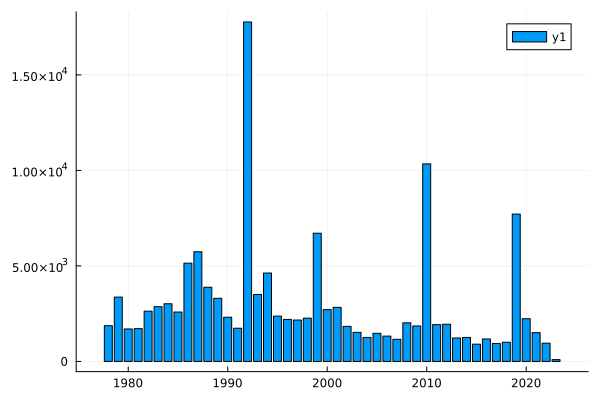

In [61]:
bar(quakes_per_year_mag2.year, quakes_per_year_mag2.count)


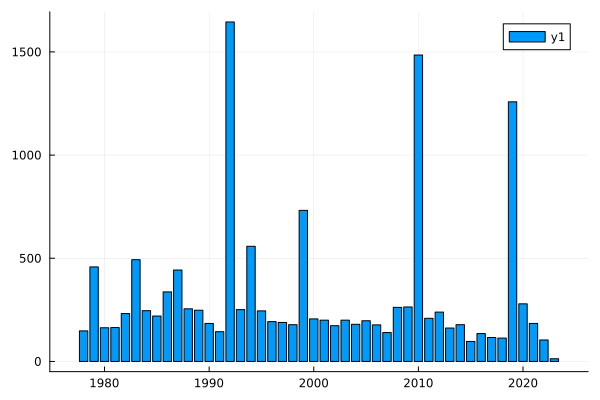

In [62]:
bar(quakes_per_year_mag3.year, quakes_per_year_mag3.count)

In [67]:
# The 3 outliers are consistent even when filtering out micro-earthquakes
# Extract the 3 outliers and find the median and mean value of earthquakes per year

sort(quakes_per_year, :count, rev=true)[1:3,:]

3×2 DataFrame
 Row │ year   count 
     │ Int64  Int64 
─────┼──────────────
   1 │  2019  62893
   2 │  1992  50402
   3 │  2010  41446

In [ ]:
# todo: Calculate measures with / without outliers in order to decide from which year to start analysis

In [34]:
# For now, the year kept is 1978

### Depth Cleanup

In [36]:
california[findall(california.Depth .< 0.001),:Depth] .= 0.0;

### Magnitude & Magnitude_Type Cleanup

In [7]:
describe(california, :all, cols=:Magnitude)

1×15 DataFrame
 Row │ variable   mean     std       min      q25      median   q75      max   ⋯
     │ Symbol     Float64  Float64   Float64  Float64  Float64  Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Magnitude  1.35497  0.652239     0.01      0.9      1.3     1.73      7 ⋯
                                                               8 columns omitted

In [8]:
combine(groupby(california, [:Magnitude_Type]), nrow => :count)

10×2 DataFrame
 Row │ Magnitude_Type  count  
     │ String3         Int64  
─────┼────────────────────────
   1 │ l               408222
   2 │ h                71048
   3 │ w                  585
   4 │ d                  232
   5 │ n                 7255
   6 │ c               177571
   7 │ b                   17
   8 │ s                    2
   9 │ e                    1
  10 │ lr                 252

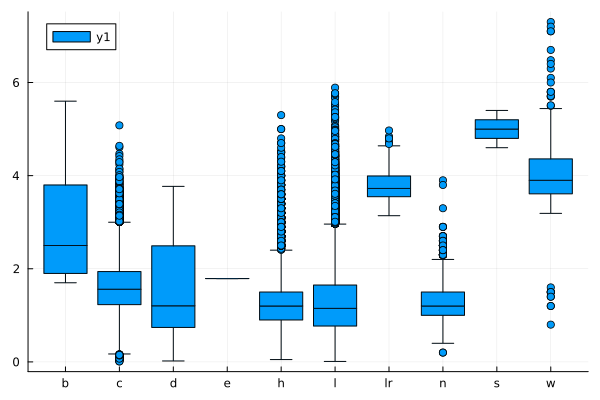

In [9]:
@df california boxplot(:Magnitude_Type, :Magnitude)

### Data visualization

### Cube split

In [ ]:
california, california_cubes = region_cube_split(california,side=5,energyRelease=true);

### Seismic Network Creation

In [ ]:
MG = create_network(california, california_cubes; edgeWeight=false)
connectivity = degree(MG);

#### Connectivity Distribution

## Motifs

### Motifs Discovery

#### Triangles

In [ ]:
inputName = "./networks/" * region * "_5km.txt"
queryName = "./networks/queryTriangle.txt";

In [ ]:
stats = motifs_discovery(inputName,queryName)

#### Tetrahedrons

In [ ]:
inputName = "./networks/" * region * "_5km.txt"
queryName = "./networks/queryTetrahedron.txt";

In [ ]:
stats = motifs_discovery(inputName,queryName)

### Motifs Analysis

#### Triangles

In [ ]:
motif = "Triangle"
filename= "./motifs" * motif * "_" * region * "_5km.csv"
motifs = readdlm(filename, ',', Int64);
motifs;

In [ ]:
motif_energy = total_mean_energy(motifs, california, california_cubes);
areas = area_triangles(motifs, california_cubes);

In [ ]:
area = [value for value in values(areas)];
totalenergy = [value[1] for value in values(motif_energy)]
meanenergy = [value[2] for value in values(motif_energy)];

#### Area weighted processing

In [ ]:
area_weight_totalenergy = []
area_weight_meanenergy = []
for key in keys(motif_energy)
    # Used to filter out zeros and very small areas (triangles on the vertical for example)
    if areas[key] > 1
        push!(area_weight_totalenergy, areas[key]/motif_energy[key][1])
        push!(area_weight_meanenergy, areas[key]/motif_energy[key][2])
    end
end

#### Tetrahedrons

In [ ]:
filename= "./motifs" * motif * "_" * region * "_5km.csv"
motifs = readdlm(filename, ',', Int64);
motifs;

In [ ]:
motif_energy = total_mean_energy(motifs, california, california_cubes)
volumes = volume_tetrahedrons(motifs,california_cubes);

In [ ]:
volume = [value for value in values(volumes)];
totalenergy = [value[1] for value in values(motif_energy)]
meanenergy = [value[2] for value in values(motif_energy)];

#### Volume weighted processing

In [ ]:
volume_weight_totalenergy = []
volume_weight_meanenergy = []
for key in keys(motif_energy)
    # Used to filter out zeros and very small areas (triangles on the vertical for example)
    if volumes[key] > 1
        push!(volume_weight_totalenergy, volumes[key]/motif_energy[key][1])
        push!(volume_weight_meanenergy, volumes[key]/motif_energy[key][2])
    end
end

### Distributions and Fits